# Reptrix Tutorial 

In this tutorial, we show how to use reptrix to assess representations of a model pretrained using self-supervised learning. 

Here we use the [STL-10](https://cs.stanford.edu/~acoates/stl10/) dataset, which contains 10 classes of images. 

We will use the [Barlow Twins](https://arxiv.org/abs/2103.03230), and [DINO](https://arxiv.org/abs/2104.14294) models as examples.

To assess the quality of the learned representations, we will use various metrics, including:

- **Alpha**: This metric computes the eigenvalues of the covariance matrix of the representations and fits a power-law distribution to them. The exponent of the power-law distribution is called the alpha exponent, which measures the heavy-tailedness of the distribution. A lower alpha exponent indicates that the representations are more discriminative.

- **RankMe**: This metric computes the rank of the covariance matrix of the representations. A higher rank indicates representations of higher capacity.


We will compute these metrics using the Reptrix library, which provides a convenient interface for representation analysis. Let's dive into the code and explore the evaluation process in detail.



### Import Libraries, get device and define feature extraction function

In [1]:
import torch
import torchvision
from tqdm import tqdm
from reptrix import alpha, rankme, lidar
import reptrix

Get the device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Function to get the features of from the pretrained encoder model using a dataset. 

In [3]:
def get_features(encoder_function, dataloader, transform=None, num_augmentations=10):
    # Loop over the dataset and collect the representations
    all_features = []

    # Loop over the dataset and collect the representations
    for i, data in enumerate(tqdm(dataloader, 0)):
        inputs, _ = data
        # apply 10 random augmentations for each image
        if transform:
            inputs = torch.cat([transform(inputs) for _ in range(num_augmentations)], dim=0)
        with torch.no_grad():
            features = encoder_function(inputs.to(device))
        if transform:
            # put the augmentations in an additonal dimension
            features = features.reshape(-1, num_augmentations, features.shape[1])
        all_features.append(features)
            
            
    # Concatenate all the features
    all_features = torch.cat(all_features, dim=0)
    return all_features

## Get the STL-10 dataset 

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4467, 0.4398, 0.4066), 
                                     (0.2242, 0.2215, 0.2239))
])

# Define additional SSL transformations for the Lidar metric evaluation
transform_ssl = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    torchvision.transforms.RandomGrayscale(p=0.2),
    torchvision.transforms.RandomResizedCrop(
        96, scale=(0.2, 1.0), 
        ratio=(0.75, (4/3)), 
        interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
])
    

# Get the STL10 test dataset to measure the quality of the representations learned by the model
testset = torchvision.datasets.STL10(root='./data', split='test', download=False, transform=transform)

# Define a dataloader to load the test dataset
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=4)

## Load the pretrained models, extract the features and compute the metrics

### 1. ResNet50 encoder trained with Barlow Twins

In this section, we will evaluate the representations learned by an encoder trained with the Barlow Twins method.

In [5]:
# Define a resnet encoder using pytorch where you can load the weights from a pre-trained model
# We will use encoder that is trained using Barlow Twins
encoder = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
# Remove the final fully connected layer so that the model outputs the 2048 feature vector
encoder = torch.nn.Sequential(*(list(encoder.children())[:-1]))

Using cache found in /home/mila/a/arnab.mondal/.cache/torch/hub/facebookresearch_barlowtwins_main
/home/mila/a/arnab.mondal/.conda/envs/equiadapt/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mila/a/arnab.mondal/.conda/envs/equiadapt/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
# Move the model to the device
encoder = encoder.to(device)

# Set the model to evaluation mode
encoder.eval()

all_representations = get_features(encoder, testloader)

100%|██████████| 32/32 [00:02<00:00, 15.31it/s]


In [7]:
metric_alpha = alpha.get_alpha(all_representations)
metric_rankme = rankme.get_rankme(all_representations)

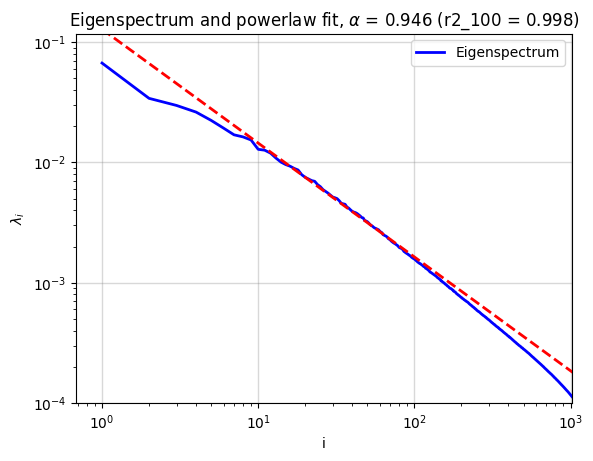

In [8]:
# Plot the eigenspectrum and the powerlaw fit
eigenspectrum = reptrix.utils.get_eigenspectrum(all_representations.cpu())

# reptrix.utils.plot_eigenspectrum(eigenspectrum)
reptrix.alpha.plot_powerlaw(eigenspectrum, metric_alpha)

In [9]:
# Get features of all the augmentations for LiDAR metric evaluation
num_augmentations = 10
all_representations_ssl = get_features(encoder, testloader, transform=transform_ssl, num_augmentations=num_augmentations)

num_samples = all_representations_ssl.shape[0] // num_augmentations

# Get the Lidar metric
lidar_metric = lidar.get_lidar(all_representations_ssl[:num_samples], num_samples, num_augmentations)


# For lidar metric evaluation, we need to use the SSL transformations over the test dataset

print(f'Values of different metrics: Alpha: {metric_alpha[0]}, Rankme: {metric_rankme}, LiDAR: {lidar_metric}')

100%|██████████| 32/32 [01:22<00:00,  2.58s/it]


Values of different metrics: Alpha: 0.9461490755307352, Rankme: 364.6608581542969, LiDAR: 122.6895980834961


### 2. Vit Encoder trained with DINO

In [10]:
# Define a vit encoder using pytorch where you can load the weights from a pre-trained model
# We will use encoder that is trained using Dino
encoder = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')


Using cache found in /home/mila/a/arnab.mondal/.cache/torch/hub/facebookresearch_dino_main


In [11]:
# Move the model to the device
encoder = encoder.to(device)

# Set the model to evaluation mode
encoder.eval()
    
all_representations = get_features(encoder.forward, testloader)

print('Shape of the representations:', all_representations.shape) 

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:02<00:00, 13.15it/s]

Shape of the representations: torch.Size([8000, 384])


In [12]:
metric_alpha = alpha.get_alpha(all_representations)
metric_rankme = rankme.get_rankme(all_representations)

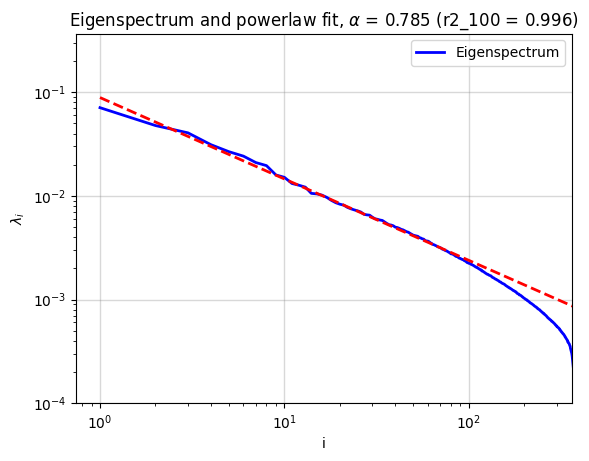

In [13]:
# Plot the eigenspectrum and the powerlaw fit
eigenspectrum = reptrix.utils.get_eigenspectrum(all_representations.cpu())

# reptrix.utils.plot_eigenspectrum(eigenspectrum)
reptrix.alpha.plot_powerlaw(eigenspectrum, metric_alpha)

In [14]:
# Get features of all the augmentations for LiDAR metric evaluation
num_augmentations = 10
all_representations_ssl = get_features(encoder, testloader, transform=transform_ssl, num_augmentations=num_augmentations)

all_representations_ssl.shape[0] // num_augmentations

# Get the Lidar metric
lidar_metric = lidar.get_lidar(all_representations_ssl[:num_samples], num_samples, num_augmentations)


# For lidar metric evaluation, we need to use the SSL transformations over the test dataset

print(f'Values of different metrics: Alpha: {metric_alpha[0]}, Rankme: {metric_rankme}, LiDAR: {lidar_metric}')

100%|██████████| 32/32 [01:21<00:00,  2.55s/it]


_LinAlgError: linalg.inv: The diagonal element 373 is zero, the inversion could not be completed because the input matrix is singular.